In [1]:
##This notebook is built around using tensorflow as the backend for keras
!KERAS_BACKEND=tensorflow python -c "from keras import backend"

Using TensorFlow backend.


In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os, glob
import pydicom as dicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import matplotlib.pyplot as plt 
import matplotlib.image as mpimage
import json
import shutil
import random
import cv2
from PIL import Image
from skimage import exposure
import skimage.morphology as morp
from skimage.filters import rank
from datetime import datetime

import PIL.TiffImagePlugin as tiff

import tensorflow as tf

from tensorflow import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

from IPython.display import display

import pandas as pd

import sklearn

import warnings
warnings.filterwarnings("ignore")


In [4]:
# If more than one callback is being used, model.fit requires a predefined list of them.
callbacks_list = (custom_early_stopping, reduce_lr) 


In [11]:
img_width, img_height = 440, 522 # Image dimensions for the DataGenerators to resize the images to

train_data_dir = '/Sidedness/Training/' # Training data folder path
validation_data_dir = '/Sidedness/Validation/' # Validation data folder path

# nb_train_samples and nb_validation samples are the numbers of images in each respective folder
# These should respectively match the numbers that print out below the cell after running it.
nb_train_samples = 220 
nb_validation_samples = 28 
epochs = 30
batch_size = 5

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2, 
    brightness_range=[0.4,1.5])  

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir, 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='binary')

Found 220 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [12]:
# Preprocessing function for image color inversion augmentation
def preprocess_color_inversion(image_pixels):
    img_color_inversion = cv2.bitwise_not(image_pixels)
    return img_color_inversion

In [13]:
# Preprocessing function for Contrast Limited Adaptive Histogram Equalization (CLAHE)
def preprocess_CLAHE(img):
    img_ = exposure.equalize_adapthist(img)
    return img_CLAHE

In [16]:
# Load the InceptionV3 model. Exclude the top layer, allowing for transfer learning.
base_model = applications.InceptionV3(weights='imagenet', include_top=False,)

In [17]:
# Build the top of the new custom model on the Inception V3 model base.
model_top = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], 
data_format=None)), 
preproc_layer = Lambda(preprocess_color_inversion, name="lambda_layer") 
preproc_layer2 = Lambda(preprocess_CLAHE, name="lambda_layer2")
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1, activation='sigmoid')) 
model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(
            train_generator,
            steps_per_epoch=nb_train_samples // batch_size,
            epochs=epochs,
            validation_data=validation_generator,
            validation_steps=nb_validation_samples // batch_size,
            callbacks= callbacks_list)


Epoch 1/30
44/44 [==============================] - 1577s 35s/step - loss: 0.6958 - accuracy: 0.5900 - val_loss: 1.2002 - val_accuracy: 0.4800
Epoch 2/30
44/44 [==============================] - 1911s 43s/step - loss: 0.5148 - accuracy: 0.7933 - val_loss: 0.6230 - val_accuracy: 0.6400
Epoch 3/30
44/44 [==============================] - 1988s 45s/step - loss: 0.3663 - accuracy: 0.8633 - val_loss: 0.2855 - val_accuracy: 0.9200
Epoch 4/30
44/44 [==============================] - 1922s 44s/step - loss: 0.2542 - accuracy: 0.9035 - val_loss: 0.0395 - val_accuracy: 1.0000
Epoch 5/30
44/44 [==============================] - 1916s 44s/step - loss: 0.1782 - accuracy: 0.9213 - val_loss: 0.3044 - val_accuracy: 0.9600
Epoch 6/30
44/44 [==============================] - 1568s 35s/step - loss: 0.2901 - accuracy: 0.8862 - val_loss: 0.6718 - val_accuracy: 0.8400
Epoch 7/30
44/44 [==============================] - 1284s 29s/step - loss: 0.1676 - accuracy: 0.9410 - val_loss: 0.0095 - val_accuracy: 1.0000

In [20]:
# Save the entire model.
!mkdir -p saved_model
model.save('saved_model/sidedness')

INFO:tensorflow:Assets written to: saved_model/my_model_2122_reducelronplateau_bestweights/assets


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


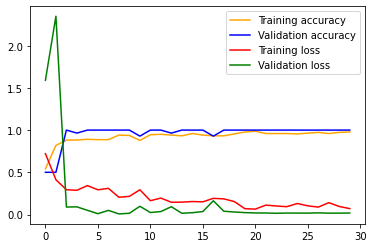

In [21]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label= 'Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()


In [2]:
new_model = keras.models.load_model('saved_model/my_model')

In [16]:
model = new_model

In [2]:
# Evaluate the model on the test set
img_width, img_height = 440, 522
test_data_dir = '/Sidedness/Test/' 
batch_size = 1 # For this purpose, its best to evaluate one image at a time.

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_data_dir, 
target_size=(img_height, img_width), 
batch_size=batch_size, 
class_mode='binary')

Found 855 images belonging to 2 classes.


In [27]:
loss, acc = new_model.evaluate(test_generator)
print('Saved model, accuracy: {:5.2f}%'.format(100 * acc))

646/646 [==============================] - 134s 203ms/step - loss: 0.0297 - accuracy: 0.9954
Saved model, accuracy: 99.54%
